# Run a Web Server in a Notebook

In this notebook, we show how to run a [Tornado](http://www.tornadoweb.org/en/stable/) or [Flask](http://flask.pocoo.org/) web server within a notebook, and access it from the public Internet. It sounds hacky, but the technique can prove useful:

1. To quickly prototype a REST API for an external web application to consume
2. To quickly expose a simple web dashboard to select external users

In this notebook, we'll demonstrate the technique using both Tornado and Flask as the web server. In both cases, the servers will listen for HTTPS connections and use a self-signed certificate. The servers will not authenticate connecting users / clients. (We want to keep things simple for this demo, but such authentication is an obvious next step in securing the web service for real-world use.)

## Define the Demo Scenario

Suppose we have completed a notebook that, among other things, can plot a point-in-time sample of data from an external source. Assume we now want to surface this plot in a very simple UI that has:

1. The title of the demo
1. The current plot
2. A refresh button that takes a new sample and updates the plot

## Create the Plotting Function

Suppose we have a function that generates a plot and returns the image as a PNG in a Python string.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import io
pd.options.display.mpl_style = 'default'

In [2]:
def plot_random_numbers(n=50):
    '''
    Plot random numbers as a line graph.
    '''
    fig, ax = plt.subplots()
    # generate some random numbers
    arr = numpy.random.randn(n)
    ax.plot(arr)
    ax.set_title('Random numbers!')
    # fetch the plot bytes
    output = io.BytesIO()
    plt.savefig(output, format='png')
    png = output.getvalue()
    plt.close()
    return png

We can test our function by showing its output inline using the `Image` utility from IPython.

/home/notebook/ka_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


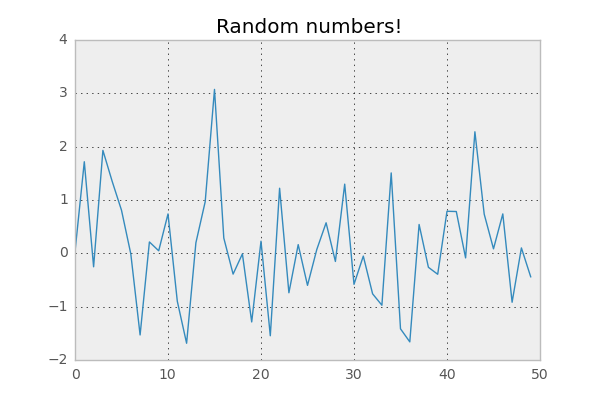

In [3]:
from IPython.display import Image
Image(plot_random_numbers())

## Create a Simple Dashboard Page

Now we'll craft a simple dashboard page that includes our plot. We don't *have* to do anything fancy here other than use an `<img>` tag and a `<button>`. But to demonstate what's possible, we'll make it pretty with Bootstrap and jQuery, and use a Jinja template that accepts the demo title as a parameter.

Note that the image tag points to a `/plot` resource on the server. Nothing dictates that we must fetch the plot image from our dashboard page. Another application could treat our web server as an API and use it in other ways.

In [4]:
import jinja2

In [5]:
page = jinja2.Template('''\
<!doctype html>
<html>
    <head>
        <link rel="stylesheet" type="text/css" href="//maxcdn.bootstrapcdn.com/bootstrap/3.3.2/css/bootstrap.min.css" />
        <title>{{ title }}</title>
    </head>
    <body>
        <nav class="navbar navbar-default">
            <div class="container-fluid">
                <div class="navbar-header">
                    <a class="navbar-brand" href="#">{{ title }}</a>
                </div>
            </div>
        </nav>
        <div class="container text-center">
            <div class="row">
                <img src="/plot" alt="Random numbers for a plot" />
            </div>
            <div class="row">
                <button class="btn btn-primary">Refresh Plot</button>
            </div>
        </div>
        <script type="text/javascript" src="//code.jquery.com/jquery-2.1.3.min.js"></script>
        <script type="text/javascript">
            console.debug('running');
            $('button').on('click', function() {
                $('img').attr('src', '/plot?'+(new Date().getTime()));
            });
        </script>
  </body>
</html>''')

We can now expose both the plotting function and the template via our web servers (Tornado first, then Flask) using the following endpoints:

* `/` will serve the dashboard HTML.
* `/plot` will serve the plot PNG.

## Run Tornado in a Notebook

First we create a self-signed certificate using the `openssl` command line library. If we had a real cert, we could use it instead.

In [6]:
%%bash
mkdir -p -m 700 ~/.ssh
openssl req -new -newkey rsa:4096 -days 365 -nodes -x509 \
    -subj "/C=XX/ST=Unknown/L=Somewhere/O=None/CN=None" \
    -keyout /home/notebook/.ssh/notebook.key -out /home/notebook/.ssh/notebook.crt

Generating a 4096 bit RSA private key
..................++
......................++
writing new private key to '/home/notebook/.ssh/notebook.key'
-----


Next we import the Tornado models we need.

In [7]:
import tornado.ioloop
import tornado.web
import tornado.httpserver

Then we define the request handlers for our two endpoints.

In [8]:
class MainHandler(tornado.web.RequestHandler):
    def get(self):
        '''Renders the template with a title on HTTP GET.'''
        self.finish(page.render(title='Tornado Demo'))

In [9]:
class PlotHandler(tornado.web.RequestHandler):
    def get(self):
        '''Creates the plot and returns it on HTTP GET.'''
        self.set_header('content-type', 'image/png')
        png = plot_random_numbers()
        self.finish(png)

Now we define the application object which maps the web paths to the handlers.

In [10]:
application = tornado.web.Application([
    (r"/", MainHandler),
    (r"/plot", PlotHandler)
])

Finally, we create a new HTTP server bound to a publicly exposed port on our notebook server (e.g., 9000) and using the self-signed certificate with corresponding key.

<div class="alert" style="border: 1px solid #aaa; background: radial-gradient(ellipse at center, #ffffff 50%, #eee 100%);">
    <div class="row">
        <div class="col-sm-1"><img src="https://knowledgeanyhow.org/static/images/favicon_32x32.png" style="margin-top: -6px"/></div>
        <div class="col-sm-11">In IBM Knowledge Anyhow Workbench, ports 9000 through 9004 are exposed on a public interface. We can bind our webserver to any of those ports.</div>
    </div>
</div>

In [11]:
server = tornado.httpserver.HTTPServer(application, ssl_options = {
    "certfile": '/home/notebook/.ssh/notebook.crt',
    "keyfile": '/home/notebook/.ssh/notebook.key'
})
server.listen(9000, '0.0.0.0')

To see the result, we need to visit the public IP address of our notebook server. For example, if our IP address is 192.168.11.10, we would visit https://192.168.11.10:9000.

<div class="alert" style="border: 1px solid #aaa; background: radial-gradient(ellipse at center, #ffffff 50%, #eee  100%);">
<div class="row">
    <div class="col-sm-1"><img src="https://knowledgeanyhow.org/static/images/favicon_32x32.png" style="margin-top: -6px"/></div>
    <div class="col-sm-11">In IBM Knowledge Anyhow Workbench, we can get our public IP address from an environment variable by executing the code below in our notebook:
<pre style="background-color: transparent">import os
os.getenv('HOST_PUBLIC_IP')</pre>
    </div>
</div>
</div>

When we visit the web server in a browser and accept the self-signed cert warning, we should see the resulting dashboard. Clicking *Refresh Plot* in the dashboard shows us a new plot. 

Note that since IPython itself is based on Tornado, we are able to run other cells and get ouput while the web server is running. In fact, we can even modify the plotting function and template and see the changes the next time we refresh the dashboard in our browser.

When we want to shut the server down, we execute the lines below. Restarting the notebook kernel has the same net effect.

In [12]:
server.close_all_connections()
server.stop()

## Run Flask in a Notebook

The same technique works with Flask, albeit with different pros and cons. First, we need to install Flask since it does not come preinstalled in the notebook environment by default.

In [13]:
!pip install flask

Cleaning up...


Now we import our Flask requirements, define our app, and create our route mappings.

In [14]:
from flask import Flask, make_response

In [15]:
flask_app = Flask('flask_demo')

In [16]:
@flask_app.route('/')
def index():
    '''Renders the template with a title on HTTP GET.'''
    return page.render(title='Flask Demo')

In [17]:
@flask_app.route('/plot')
def get_plot():
    '''Creates the plot and returns it on HTTP GET.'''
    response = make_response(plot_random_numbers())
    response.mimetype = 'image/png'
    return response

Finally, we run the Flask web server. Flask supports the generation of an ad-hoc HTTP certificate and key so we don't need to explicitly put one on disk like we did in the case of Tornado.

In [18]:
flask_app.run(host='0.0.0.0', port=9000, ssl_context='adhoc')

Unlike in the Tornado case, the run command above blocks the notebook kernel from returning for as long as the web server is running. To stop the server, we need to interrupt the kernel (*Kernel* &rarr; *Interrupt*). 

## Run Flask in a Tornado WSGIContainer

If we are in love with Flask syntax, but miss the cool, non-blocking ability of Tornado, we can run the Flask application in a Tornado WSGIContainer like so.

In [21]:
from tornado.wsgi import WSGIContainer
server = tornado.httpserver.HTTPServer(WSGIContainer(flask_app), ssl_options = {
    "certfile": '/home/notebook/.ssh/notebook.crt',
    "keyfile": '/home/notebook/.ssh/notebook.key'
})
server.listen(9000, '0.0.0.0')

And once we do, we can view the dashboard in a web browser even while executing cells in the notebook. When we're done, we can cleanup with the same logic as in the pure Tornado case.

In [22]:
server.close_all_connections()
server.stop()

## Conclusion

In this notebook, we:

* Defined a simple function that returns a PNG of a plot
* Defined a template that renders a very simple HTML dashboard
* Exposed two HTTPS endpoints in Tornado, one for the dashboard HTML and one for the plot
* Exposed two HTTPS endpoints in Flask for the same resources
* Exposed two HTTPS endpoints in Flask + Tornado for the same resources

Of course, what we chose to expose was specific to the demo scenario. For example, we could have just as easily created a REST API that accepted feature values for classification and feedback about whether the classification was right or not for future training.

While the result is not "production ready", it does allow us to expose prototype code to other users without worrying about migrating our work from notebook(s) to other environments.

<div class="alert" style="border: 1px solid #aaa; background: radial-gradient(ellipse at center, #ffffff 50%, #eee 100%);">
<div class="row">
    <div class="col-sm-1"><img src="https://knowledgeanyhow.org/static/images/favicon_32x32.png" style="margin-top: -6px"/></div>
    <div class="col-sm-11">This notebook was created using <a href="https://knowledgeanyhow.org">IBM Knowledge Anyhow Workbench</a>.  To learn more, visit us at <a href="https://knowledgeanyhow.org">https://knowledgeanyhow.org</a>.</div>
    </div>
</div>